# Trabajo Práctico 1: Análisis Exploratorio - Organización de Datos

**Alumnos y Padrón**
+ Craviotto Roitbarg, Mateo Exequiel - 106255 
+ Gómez, Joaquín - 103735

https://github.com/joaqogomez/Organizacion-de-datos-fiuba


## Introducción

En el presente trabajo se propone realizar un análisis de los datos recolectados por una agencia sobre las personas que pagan los impuestos.
El objetivo de la agencia es utilizar la información recolectada para dirigir campañas y poder dirigir a los fiuagentes recaudadores a inspeccionar.


## Objetivos
Los objetivos de este notebook es:
- Entender los datos.
- Ver como se relacionan entre si.
- Poder sacar alguna conclusión o descubrir un patrón.
- Indicar cuáles son los factores más importantes que determinan si una persona tiene altos o bajos ingresos. 
- Armar un baseline.

## Configuraciones Iniciales
Primero, importamos las bibliotecas que vamos a utilizar:

In [2]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

## Carga del set de datos
Cargamos el dataset:

In [3]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("Dataset/impuestos.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)
df = pd.read_csv("Dataset/impuestos.csv")

## Limpieza del set de datos

Despues de cargar el dataset, chequeamos qué campos tenemos y si tienen valores NULL.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            32561 non-null  int64 
 1   barrio                                      31978 non-null  object
 2   categoria_de_trabajo                        30725 non-null  object
 3   edad                                        32561 non-null  int64 
 4   educacion_alcanzada                         32561 non-null  object
 5   estado_marital                              32561 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64 
 7   genero                                      32561 non-null  object
 8   horas_trabajo_registradas                   32561 non-null  int64 
 9   religion                                    32561 non-null  object
 10  rol_familiar_registrad

Se observa que tenemos valores null en las columnas barrio, categoria_de_trabajo y trabajo.

Verificamos que nuestra variable target, en este caso "tiene_alto_valor_adquisitivo" no tenga valores inválidos

In [5]:
df.tiene_alto_valor_adquisitivo.value_counts()

0    24720
1     7841
Name: tiene_alto_valor_adquisitivo, dtype: int64

Se puede ver que solo tiene dos valores disponibles que son 0 y 1 como necesitamos.

Luego, utilizando el metodo value_counts en cada columna revisamos que no hayan campos vacios, con guiones u otros valores que significan que no hay algo completo.
Después de verificar cada columna, vimos que esto no sucede en ninguna columna.

A continuación, observemos la cantidad de valores nulos para cada feature. Hay valores nulos en las columas 'barrio', 'categoria_de_trabajo' y 'trabajo' como habiamos visto anteriormente.


In [6]:
df.isnull().sum()

anios_estudiados                                 0
barrio                                         583
categoria_de_trabajo                          1836
edad                                             0
educacion_alcanzada                              0
estado_marital                                   0
ganancia_perdida_declarada_bolsa_argentina       0
genero                                           0
horas_trabajo_registradas                        0
religion                                         0
rol_familiar_registrado                          0
tiene_alto_valor_adquisitivo                     0
trabajo                                       1843
dtype: int64

Y estos serían los porcentajes de valores nulos para cada feature:

In [7]:
(df.isnull().mean() * 100).to_frame('porcentaje nulls')

,porcentaje nulls
anios_estudiados,0.000000
barrio,1.790486
categoria_de_trabajo,5.638647
edad,0.000000
educacion_alcanzada,0.000000
estado_marital,0.000000
ganancia_perdida_declarada_bolsa_argentina,0.000000
genero,0.000000
horas_trabajo_registradas,0.000000
religion,0.000000


Si hacemos un análisis de los valores nulos en las columnas categoría de trabajo y trabajo, podemos encontrar una relación entre estas

In [8]:
trabajo_y_categoria_na = df[df['categoria_de_trabajo'].isna() & df['trabajo'].isna()]
print(f"Hay {len(trabajo_y_categoria_na)} filas con valores nulos en trabajo y categoría")


Hay 1836 filas con valores nulos en trabajo y categoría


Si miramos los números anteriores,se puede ver que la totalidad de los registros que tienen categoria de trabajo "NaN", tambien tienen trabajo "NaN" .Según nuestro analisis, nosotros no podriamos definirles ni una categoria ni un trabajo a estos casos,por lo tanto, tomamos la decisión de eliminar los que tienen categoria_de_trabajo y trabajo "NaN" ya que consideramos que estos registros son ruido.

In [9]:
df = df.dropna(subset=['categoria_de_trabajo'])
df.isnull().sum()

anios_estudiados                                0
barrio                                        556
categoria_de_trabajo                            0
edad                                            0
educacion_alcanzada                             0
estado_marital                                  0
ganancia_perdida_declarada_bolsa_argentina      0
genero                                          0
horas_trabajo_registradas                       0
religion                                        0
rol_familiar_registrado                         0
tiene_alto_valor_adquisitivo                    0
trabajo                                         7
dtype: int64

Con los valores "NaN" que nos quedaron decidimos reemplazar los valores "NaN" de la categoría barrio con una categoría llamada 'No responde' y los trabajos que nos quedaron "NaN" por una categoria llamada "desempleado" ya que estos registros que nos quedan tienen categoria de trabajo "sin_trabajo".


In [10]:
trabajo_na = df[df['trabajo'].isna()]
trabajo_na.categoria_de_trabajo.value_counts()

sin_trabajo    7
Name: categoria_de_trabajo, dtype: int64

In [11]:
df = df.replace(np.nan, {'trabajo': 'desempleado', 'barrio': 'No responde'})
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

anios_estudiados                              0
barrio                                        0
categoria_de_trabajo                          0
edad                                          0
educacion_alcanzada                           0
estado_marital                                0
ganancia_perdida_declarada_bolsa_argentina    0
genero                                        0
horas_trabajo_registradas                     0
religion                                      0
rol_familiar_registrado                       0
tiene_alto_valor_adquisitivo                  0
trabajo                                       0
dtype: int64

Podemos ver que ya no tenemos registros con valores nulos.


Por último,vamos a revisar que las columnas no numéricas que deberían contener solo caracteres, contengan lo que deberían contener. Obviamos la columna educacion_alcanzada, ya que esta puede tener números.

In [12]:
columnas_no_numericas = ['barrio', 'categoria_de_trabajo', 'estado_marital', 'genero', 'religion', 'rol_familiar_registrado', 'trabajo']
for c in columnas_no_numericas:
    print(df[c].str.contains('1|2|3|4|5|6|7|8|9|0|-|#|%|&|!|@').any())      

False
False
False
False
False
False
False


Una vez limpio el dataset,podemos continuar con el análisis de los datos.


## Análisis de los datos

Para hacer el análisis del set de datos, primero vamos a realizarnos unas preguntas simples a modo de guía, para hacer un desarrollo a partir de estas. Las preguntas que surgieron en este caso son:

- ¿Está el barrio en el que residen las personas relacionado con sus ingresos?
- ¿Existe alguna relacion entre el género de una persona y sus ingresos?
- ¿En qué afecta el nivel de educación alcanzada?
- ¿El estado marital influye en nuestra variable objetivo?
- ¿Si un contribuyente declara ganancia/pérdida en la bolsa, afecta esto fuertemente sus ingresos?
- ¿La cantidad de años estudiados es un factor influyente?
- ¿Se debería tener en cuenta la religión?
- ¿Influye la edad en los ingresos de la persona?
- ¿Es el rol familiar registrado determinante en los ingresos de las personas?
- ¿Es influyente la categoría de trabajo?
- ¿Es el tipo de trabajo un factor fundamental para determinar los ingresos de una persona?
- ¿La cantidad de horas trabajadas influye en el valor adquisitivo de la gente?

### ¿Hay relación entre el barrio y los ingresos?

Comencemos observando la distribución de los distintos barrios en el dataset.

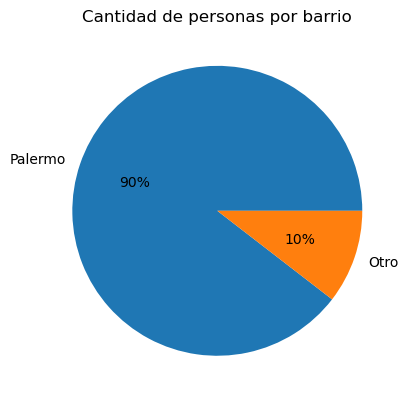

In [13]:
def cambiar_barrio(barrio):
    if barrio == "Palermo":
        return "Palermo"
    else:
        return "Otro"

df_para_grafico_barrio = df.copy()
df_para_grafico_barrio.barrio.value_counts()
df_para_grafico_barrio['barrio'] = df['barrio'].apply(cambiar_barrio)


plt.figure(figsize=(6.4, 4.8), dpi=100)
df_para_grafico_barrio['barrio'].value_counts().iloc[:4].plot(kind='pie', autopct='%1.0f%%')
plt.title('Cantidad de personas por barrio')
plt.ylabel('')
plt.show()

Se puede observar claramente que el barrio predominante es Palermo, el resto fueron agrupados porque su porcentaje es muy bajo. A continuación, vamos a ver como se distribuye la población en estos dos grupos según nuestra variable target.

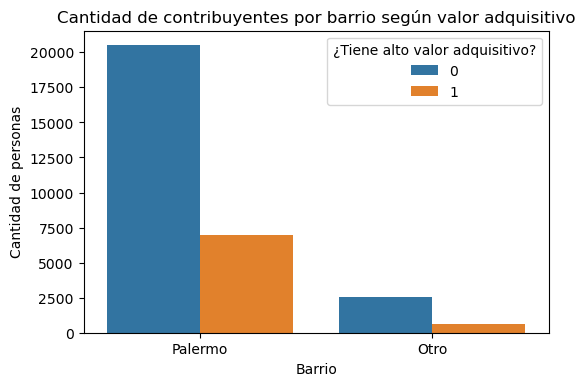

In [14]:
plt.figure(dpi=100)
sns.countplot(data=df_para_grafico_barrio, x='barrio', hue='tiene_alto_valor_adquisitivo', order=df_para_grafico_barrio['barrio'].value_counts().index)
plt.title("Cantidad de contribuyentes por barrio según valor adquisitivo")
plt.ylabel("Cantidad de personas")
plt.xlabel("Barrio")
plt.legend(title="¿Tiene alto valor adquisitivo?")
plt.show()

Podemos observar, que la mayoria de la población de nuestra variable target, se encuentra en el barrio de Palermo, hecho que tiene sentido ya que la mayoria de la población total se encuentra acá. Decidimos igualmente, analizar la categoria que definimos como 'Otro' y ver si hay alguna relación.


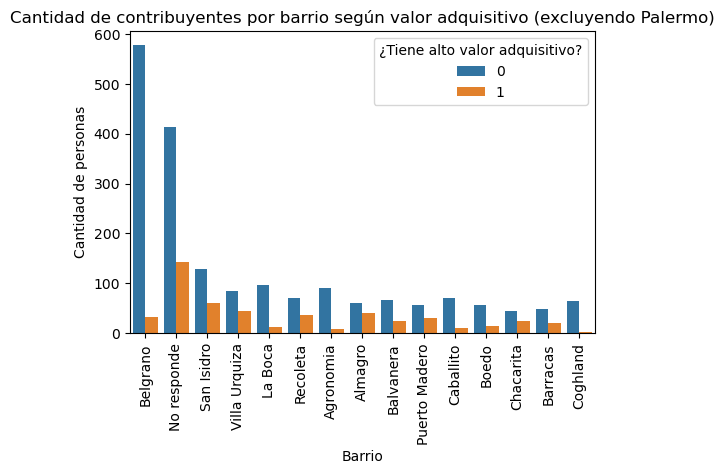

In [15]:
df_sin_palermo = df[df['barrio'] != 'Palermo']
plt.figure(dpi=100)
sns.countplot(data=df_sin_palermo, x='barrio', hue='tiene_alto_valor_adquisitivo',order=df_sin_palermo['barrio'].value_counts().iloc[:15].index)
plt.xticks(rotation=90)
plt.title("Cantidad de contribuyentes por barrio según valor adquisitivo (excluyendo Palermo)")
plt.ylabel("Cantidad de personas")
plt.xlabel("Barrio")
plt.legend(title="¿Tiene alto valor adquisitivo?")
plt.show()

Se puede observar que hay barrios que tienen mayoría de personas con bajo nivel adquisitivo, como por ejemplo Belgrano, La Boca y Coghlan, pero nos pareció que se trataba de muy pocos casos como para tener en cuenta una futura relación en nuestro baseline.


## ¿Existe alguna relación entre el género de una persona y sus ingresos?

Comenzamos primero por analizar cómo se distribuye el género en nuestro dataset

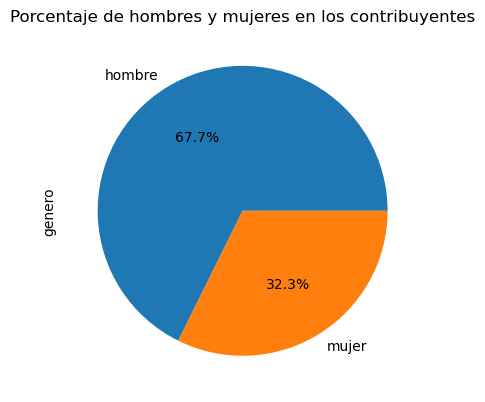

In [16]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
df['genero'].value_counts().plot(kind='pie', autopct='%.01f%%')
plt.title('Porcentaje de hombres y mujeres en los contribuyentes')
plt.show()

El gráfico nos muestra que aproximadamente 2/3 de las personas en nuestro dataset son hombres.

A continuación, nos fijamos cómo se distribuyen los ingresos según el género:


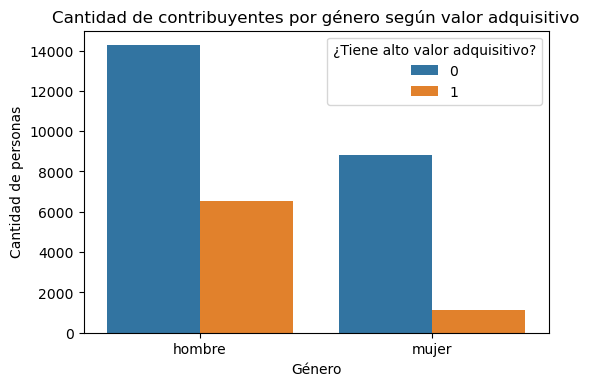

In [17]:
plt.figure(dpi=100)
sns.countplot(data=df, x='genero', hue='tiene_alto_valor_adquisitivo')
plt.title("Cantidad de contribuyentes por género según valor adquisitivo")
plt.ylabel("Cantidad de personas")
plt.xlabel("Género")
plt.legend(title="¿Tiene alto valor adquisitivo?")
plt.show()

Observado este gráfico, consideramos que el género no tiene un gran impacto en los ingresos de la persona.
Lo único que podemos afirmar es que si tenemos alguien de altos ingresos, existe una probabilidad muy alta de que sea una persona de género masculino.

## ¿En qué afecta el nivel de educación alcanzada?

Para ver esta relación, decidimos separar a la población en categorías según el nivel educativo alcanzado. Siendo estos "Universitario", "Secundario", "Primario" y "Jardin".

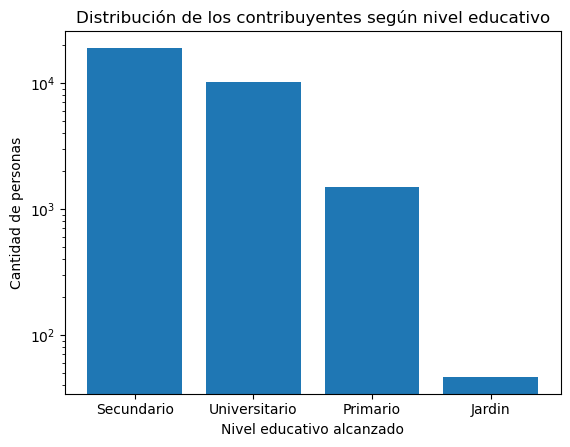

In [18]:
def definir_nivel(nivel):
    if nivel.startswith("uni"):
        return "Universitario"
    elif nivel.endswith("anio"):
        return "Secundario"
    elif nivel.endswith("grado"):
        return "Primario"
    else:
        return "Jardin"

df['nivel_educativo_alcanzado'] = df['educacion_alcanzada'].apply(definir_nivel)

plt.figure(figsize=(6.4, 4.8), dpi=100)
personas_por_nivel_educativo = (df['nivel_educativo_alcanzado'].value_counts().sort_values(ascending=False))
plt.bar(personas_por_nivel_educativo.index, personas_por_nivel_educativo.values)
plt.yscale("log")
plt.ylabel("Cantidad de personas")
plt.xlabel("Nivel educativo alcanzado")
plt.title("Distribución de los contribuyentes según nivel educativo")
plt.show()

Elegimos un gráfico con escala logarítmica, para que se pueda visualizar la cantidad de gente de jardín, ya que con una escala lineal no se podía apreciar correctamente.

Como se puede ver, la mayoría de los contribuyentes alcanzaron una educación de nivel secundario y universitario.
A continuación, vamos a analizar el nivel educativo según el valor adquisitivo.

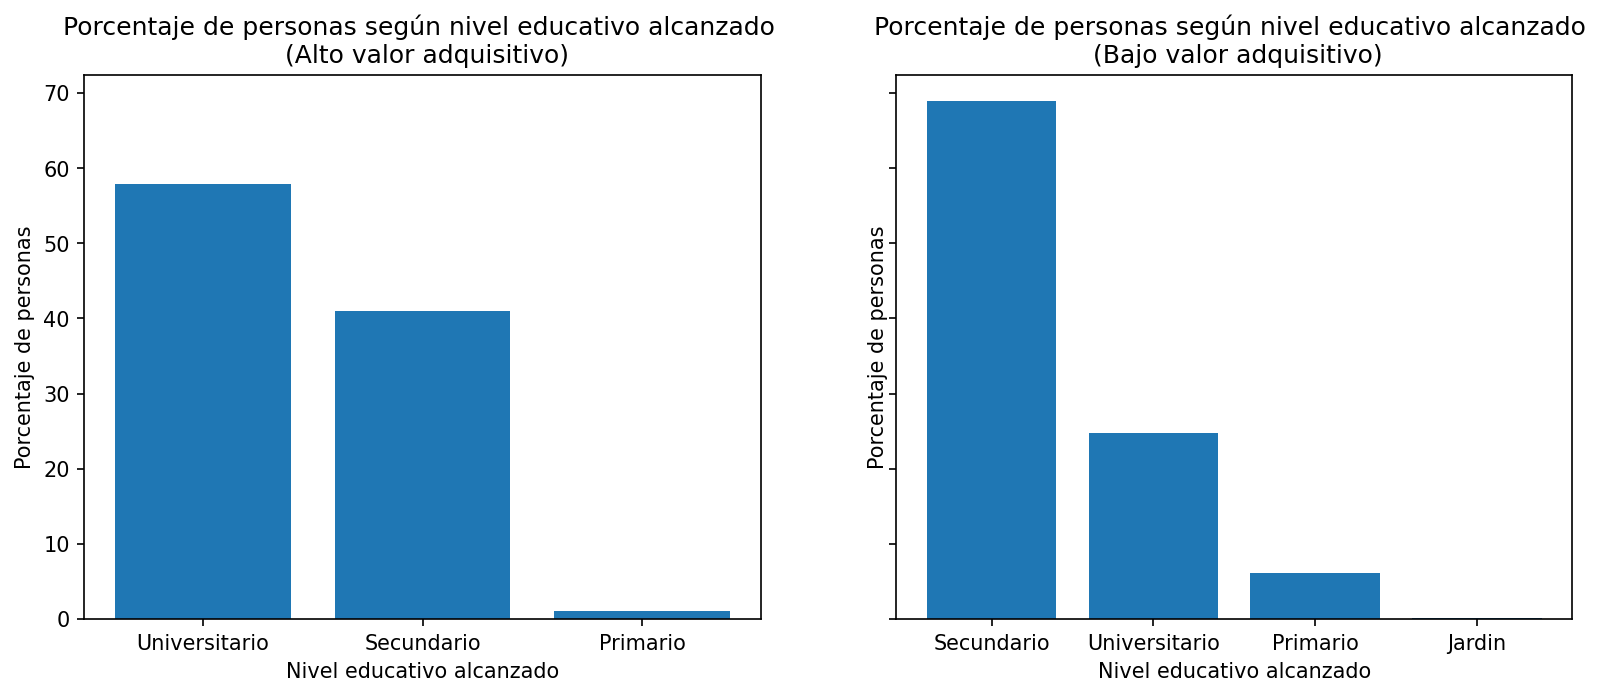

In [19]:
alto_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 1]
bajo_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 0]

porcentaje_alto_valor_adquisitivo = (
    alto_valor_adquisitivo.nivel_educativo_alcanzado.value_counts() / 
    len(alto_valor_adquisitivo) * 100
)
porcentaje_bajo_valor_adquisitivo = (
    bajo_valor_adquisitivo.nivel_educativo_alcanzado.value_counts() / 
    len(bajo_valor_adquisitivo) * 100
)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=150, figsize=(6.4 * 2, 4.8))

axes[0].bar(porcentaje_alto_valor_adquisitivo.index, porcentaje_alto_valor_adquisitivo.values)
axes[0].set_title("Porcentaje de personas según nivel educativo alcanzado \n (Alto valor adquisitivo)")
axes[0].set_xlabel("Nivel educativo alcanzado")
axes[0].set_ylabel("Porcentaje de personas")

axes[1].bar(porcentaje_bajo_valor_adquisitivo.index, porcentaje_bajo_valor_adquisitivo.values)
axes[1].set_title("Porcentaje de personas según nivel educativo alcanzado \n (Bajo valor adquisitivo)")
axes[1].set_xlabel("Nivel educativo alcanzado")
axes[1].set_ylabel("Porcentaje de personas")

plt.show()

Se observa a simple vista que la mayoría de las personas con altos ingresos tienen nivel educativo universitario, con gran cantidad de personas con estudios secundarios. Mientras que en las personas con bajos ingresos, se puede ver que la mayoría son personas con estudios secundarios, pero en este caso la población universitaria no es tan significativa como en el caso anterior.
Además, se visualiza que disminuye mucho la cantidad de personas con estudios primarios y jardín, esta última no tiene ningun caso con alto valor adquisitivo.

Por lo tanto, creemos que puede llegar a haber una relación entre el nivel educativo y los altos ingresos.

## ¿El estado marital influye en nuestra variable objetivo?

Para ver esta relación primero decidimos ver cómo se distribuye la variable en nuestra poblacion:

In [20]:
df.estado_marital.value_counts()

matrimonio_civil      14340
sin_matrimonio         9917
divorciado             4259
separado                959
viudo_a                 840
pareja_no_presente      389
matrimonio_militar       21
Name: estado_marital, dtype: int64

Decidimos juntar los grupos : 
- Las categorías "matrimonio_civil" y "matrimonio_militar" hacerla una sola categoría llamada "matrimonio"
- El resto de las categorías unificarlas en la categoría llamada "sin_matrimonio", ya que representan a personas que no están con otra persona para la ley

Para esto creamos una nueva columna "tiene_matrinomio".


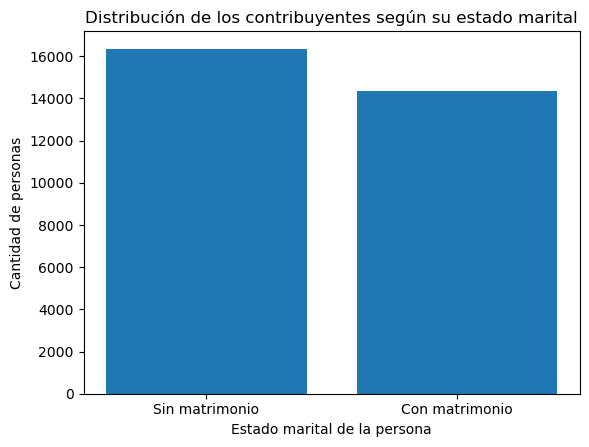

In [21]:
def definir_estado_marital(estado_marital):
    if estado_marital.startswith('matrimonio'):
        return 'Con matrimonio'
    else:
        return 'Sin matrimonio'
    
df['tiene_matrimonio'] = df['estado_marital'].apply(definir_estado_marital)

plt.figure(figsize=(6.4, 4.8), dpi=100)
personas_por_estado_marital = (df['tiene_matrimonio'].value_counts().sort_values(ascending=False))
plt.bar(personas_por_estado_marital.index, personas_por_estado_marital.values)
plt.ylabel("Cantidad de personas")
plt.xlabel("Estado marital de la persona")
plt.title("Distribución de los contribuyentes según su estado marital")
plt.show()

Como se puede ver en el gráfico, nuestra población esta dividida casi de forma equitativa entre los que tienen matrimonio y los que no, siendo estos últimos mayoría por un pequeño margen.

A continuación, revisamos cómo se relaciona esto con nuestra variable target:

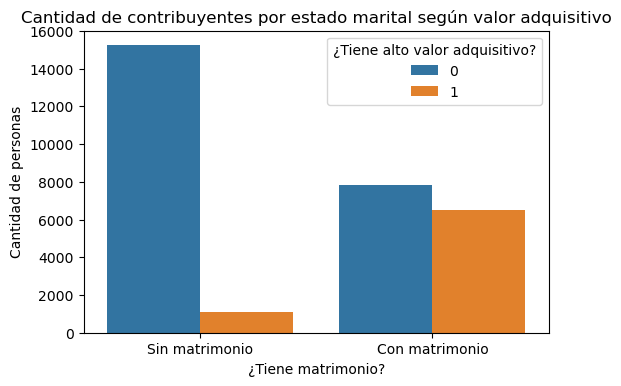

In [22]:
personas_con_alto_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 1]
plt.figure(dpi=100)
sns.countplot(data=df, x='tiene_matrimonio', hue='tiene_alto_valor_adquisitivo')
plt.title("Cantidad de contribuyentes por estado marital según valor adquisitivo")
plt.ylabel("Cantidad de personas")
plt.xlabel("¿Tiene matrimonio?")
plt.legend(title="¿Tiene alto valor adquisitivo?")
plt.show()

Se puede observar que existe una relación entre el nivel de ingresos y el estado marital de las personas. La mayoría de las personas sin matrimonio son de ingresos bajos, mientras que en la población con matrimonio se distribuye casi de forma equitativa.
Además como conclusión, en nuestra variable target, la mayoría de las personas contrajeron matrimonio. Lo mostramos en el siguiente gráfico:

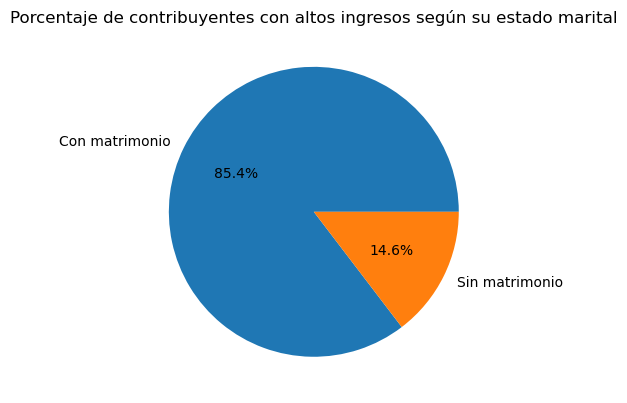

In [23]:
personas_con_alto_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 1]
plt.figure(figsize=(6.4, 4.8), dpi=100)
personas_con_alto_valor_adquisitivo.tiene_matrimonio.value_counts().plot(kind='pie', autopct='%.01f%%')
plt.title('Porcentaje de contribuyentes con altos ingresos según su estado marital')
plt.ylabel("")
plt.show()

## ¿Si un contribuyente declara ganancia/pérdida en la bolsa, afecta esto fuertemente sus ingresos?


Analizamos primero un histograma de los resultados en la bolsa de la población en general. Para ello, creemos conveniente segmentar este feature en las categorías: ganancia, pérdida y cero, para ver cómo está distribuido. A partir de estas comenzamos el análisis.

In [24]:
def definir_resultado_en_bolsa(resultado_en_bolsa):
    if resultado_en_bolsa > 0:
        return 'Ganancia'
    elif resultado_en_bolsa < 0:
        return 'Pérdida'
    else:
        return 'Cero'
    
df['resultado_en_bolsa_argentina'] = df['ganancia_perdida_declarada_bolsa_argentina'].apply(definir_resultado_en_bolsa)

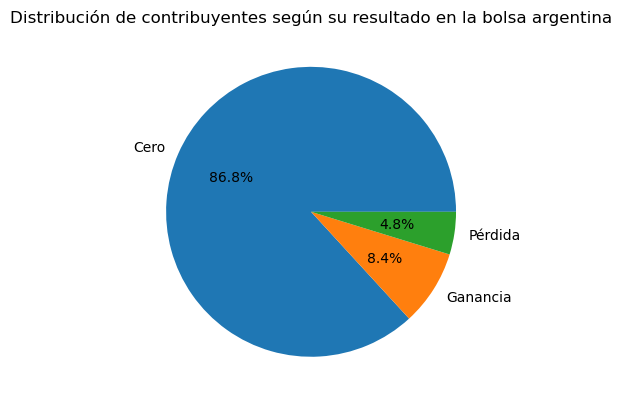

In [25]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
df['resultado_en_bolsa_argentina'].value_counts().plot(kind='pie', autopct='%.01f%%')
plt.title('Distribución de contribuyentes según su resultado en la bolsa argentina')
plt.ylabel("")
plt.show()

Como se puede observar, es clara la predominancia del cero, por lo que la gran mayoría de la población no tuvo ni ganancias ni pérdidas en la bolsa argentina. Decidimos ver si las ganancias y las pérdidas tienen alguna correlación con nuestra variable objetivo, por lo que dejamos a las personas con resultado "Cero" fuera del análisis.

Comenzamos analizando las ganancias en la bolsa.

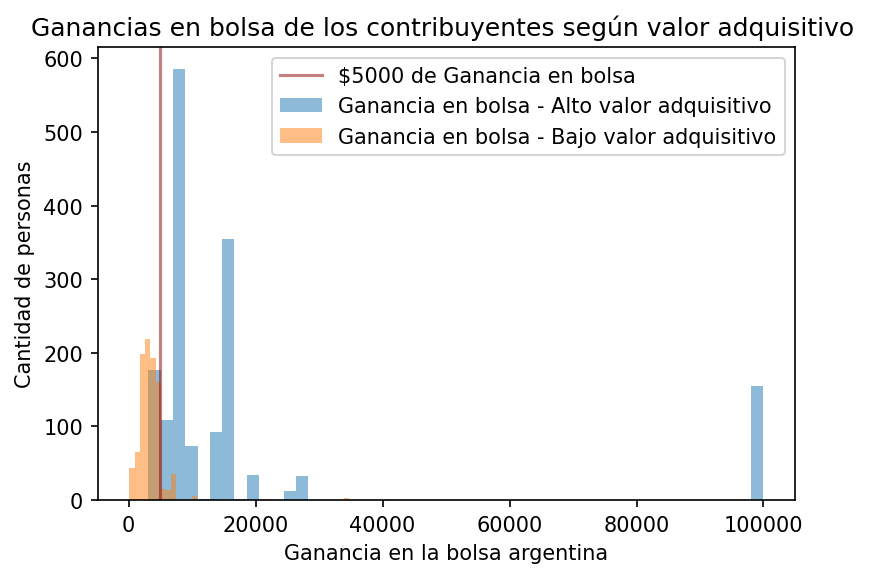

In [26]:
# Ganancia

alto_valor_adquisitivo = df[(df['tiene_alto_valor_adquisitivo'] == 1) & (df['ganancia_perdida_declarada_bolsa_argentina'] > 0)]
bajo_valor_adquisitivo = df[(df['tiene_alto_valor_adquisitivo'] == 0) & (df['ganancia_perdida_declarada_bolsa_argentina'] > 0)]
plt.figure(dpi=150)
plt.hist(
    alto_valor_adquisitivo['ganancia_perdida_declarada_bolsa_argentina'],
    label="Ganancia en bolsa - Alto valor adquisitivo",
    bins=50,
    alpha=0.5

)
plt.hist(
    bajo_valor_adquisitivo['ganancia_perdida_declarada_bolsa_argentina'],
    label="Ganancia en bolsa - Bajo valor adquisitivo",
    bins=50,
    alpha=0.5
)
plt.title("Ganancias en bolsa de los contribuyentes según valor adquisitivo ")
plt.xlabel("Ganancia en la bolsa argentina")
plt.ylabel("Cantidad de personas")
plt.axvline(x=5000, color="darkred", label="$5000 de Ganancia en bolsa", alpha=0.5)
plt.legend()

plt.show()

Podemos ver que hay una evidente división entre los que tienen altos ingresos y los que no. Esta se encuentra aproximadamente a partir de los $5000 de ganancia. Esto es un factor interesante para la predicción del alto valor adquisitivo.

A continuación, analizamos las pérdidas en la bolsa argentina.

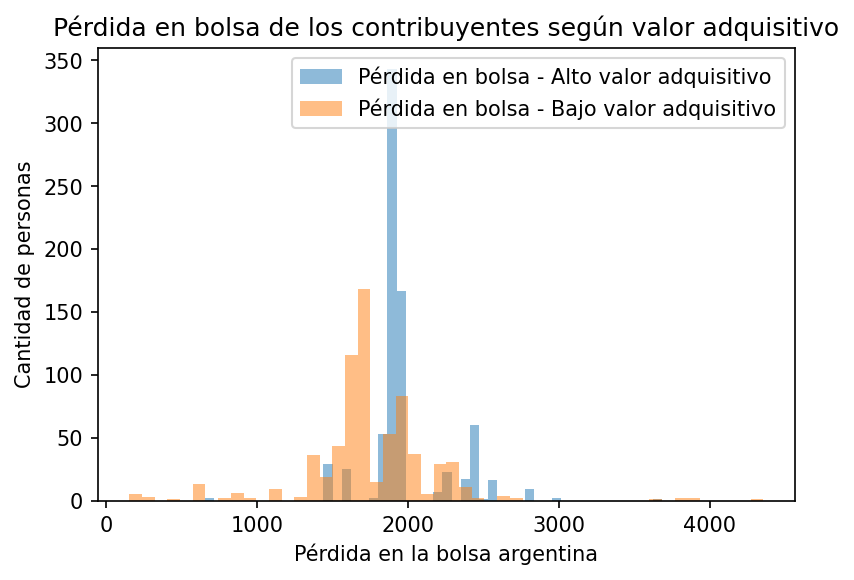

In [27]:
# Pérdida
alto_valor_adquisitivo = df[(df['tiene_alto_valor_adquisitivo'] == 1) & (df['ganancia_perdida_declarada_bolsa_argentina'] < 0)]
bajo_valor_adquisitivo = df[(df['tiene_alto_valor_adquisitivo'] == 0) & (df['ganancia_perdida_declarada_bolsa_argentina'] < 0)]
plt.figure(dpi=150)
plt.hist(
    alto_valor_adquisitivo['ganancia_perdida_declarada_bolsa_argentina'].abs(),
    label="Pérdida en bolsa - Alto valor adquisitivo",
    bins=50,
    alpha=0.5
)
plt.hist(
    bajo_valor_adquisitivo['ganancia_perdida_declarada_bolsa_argentina'].abs(),
    label="Pérdida en bolsa - Bajo valor adquisitivo",
    bins=50,
    alpha=0.5
)
plt.title("Pérdida en bolsa de los contribuyentes según valor adquisitivo")
plt.xlabel("Pérdida en la bolsa argentina")
plt.ylabel("Cantidad de personas")
plt.legend()

plt.show()

En este caso, a diferencia del anterior, no se tiene una clara distinción entre los dos grupos, por lo que no vamos a tomar en cuenta el factor pérdida en la bolsa para el análisis.

## ¿La cantidad de años estudiados es un factor influyente?

Vamos a visualizar primero cómo se distribuye la variable "anios_estudiados" dentro de la población.

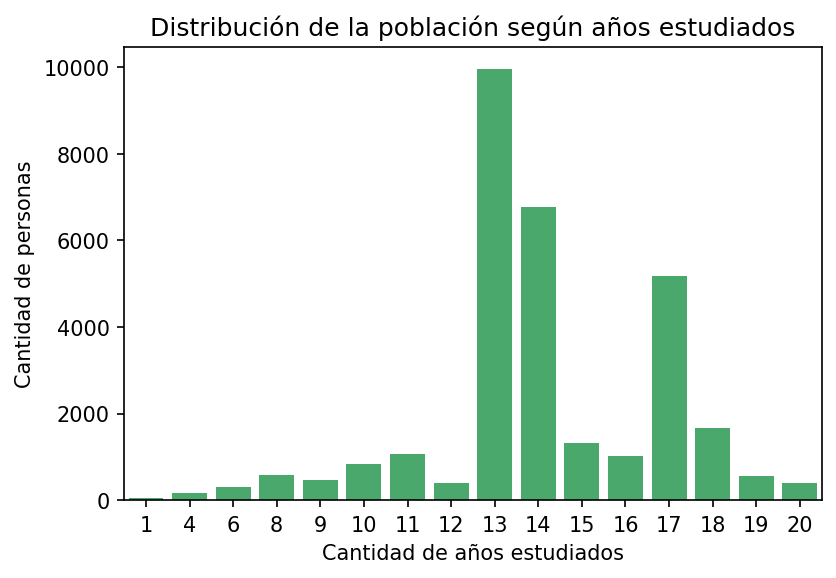

In [28]:
plt.figure(dpi=150)
sns.countplot(data=df, x='anios_estudiados', color=(0.23, 0.72, 0.41))
plt.title("Distribución de la población según años estudiados")
plt.xlabel("Cantidad de años estudiados")
plt.ylabel("Cantidad de personas")
plt.show()

Decidimos ver a continuación si existe alguna relación entre la cantidad de años estudiados y nuestra variable target. Para ello, creemos conveniente agrupar en categorías. Los valores hasta los 10 años los agrupamos en una misma categoría, y el resto los dejamos específicos por año.

Text(0.5, 1.0, 'Cantidad de personas por años estudiados según su nivel de ingresos')

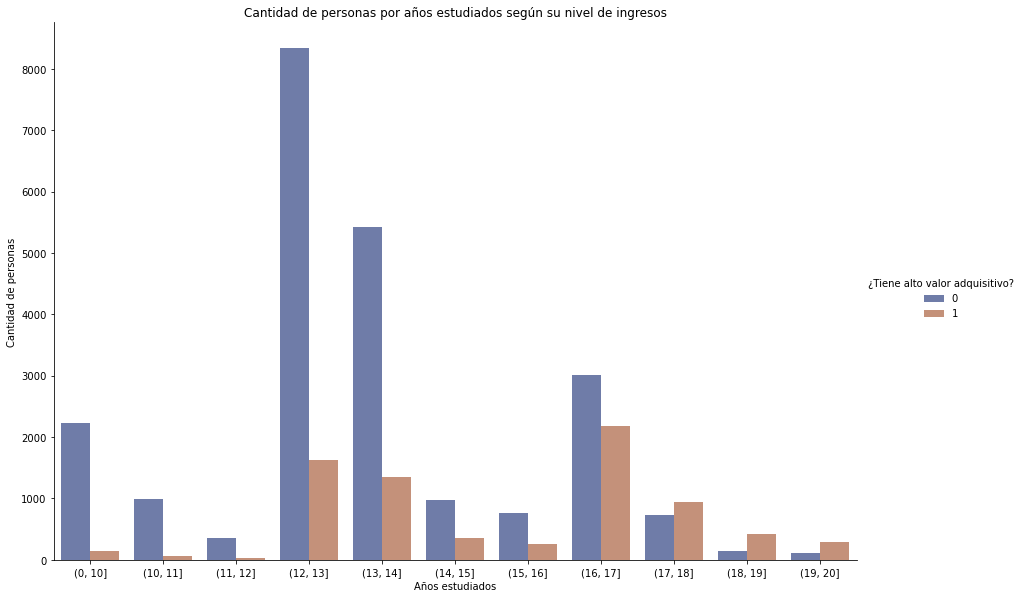

In [29]:
bins = [0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
categorias_anios = pd.cut(df['anios_estudiados'], bins=bins)

tipo_ingresos_por_anios_estudiados = df.groupby(by=categorias_anios)['tiene_alto_valor_adquisitivo'].value_counts()
df_aux = tipo_ingresos_por_anios_estudiados.to_frame()
df_aux.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de personas'},inplace=True)
df_aux.reset_index(inplace=True)
df_aux.rename(columns={'tiene_alto_valor_adquisitivo':'¿Tiene alto valor adquisitivo?','anios_estudiados':'Años estudiados'},inplace=True)

sns.catplot(
    data=df_aux, kind="bar",
    x="Años estudiados", y="Cantidad de personas", hue="¿Tiene alto valor adquisitivo?",
    ci=None, palette="dark", alpha=.6, height=8,aspect=1.5
)
plt.title("Cantidad de personas por años estudiados según su nivel de ingresos")

Se puede observar que la mayor cantidad de personas que tienen bajo nivel adquisitivo tienen 14 o menos años de estudio. A su vez, la mayoria de personas con altos ingresos tienen 14 o más años de estudio. Decidimos mostrar esto en el siguiente gráfico:

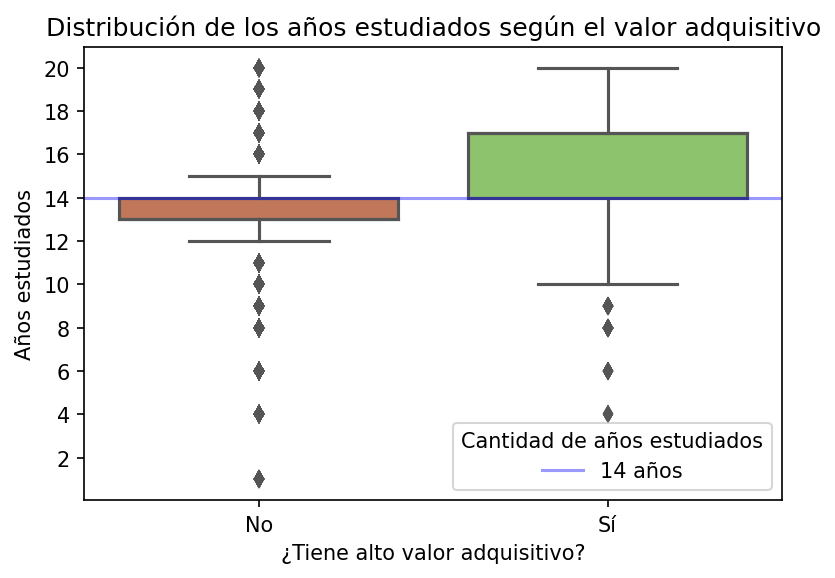

In [30]:
plt.figure(dpi=150)
plt.title("Distribución de los años estudiados según el valor adquisitivo")
sns.boxplot(
    data=df,
    y='anios_estudiados',
    x='tiene_alto_valor_adquisitivo',
    palette=['#D17049', "#89D15E"]
)
plt.ylabel("Años estudiados")
plt.xlabel("¿Tiene alto valor adquisitivo?")
plt.xticks([False, True], ["No", "Sí"])
plt.yticks(np.arange(2, 22, 2).tolist())
plt.axhline(y=14, color="blue", label="14 años", alpha=0.4)
plt.legend(title="Cantidad de años estudiados")
plt.show()

La línea graficada corresponde con los 14 años de estudio.
Se puede ver con claridad que el cuantil 75(Q3) de la población con bajo valor adquisitivo se encuentra sobre esta línea, mientras que el cuantil 25(Q1) de la población con alto valor adquisitivo se encuentra sobre la misma. Por lo tanto, la mayoría de la población con alto valor adquisitivo tiene más de 14 años de estudios.

Por lo tanto, la cantidad de años estudiados es un factor influyente en los ingresos de los contribuyentes.


## ¿Se debería tener en cuenta la religión?

Primero comenzamos viendo cómo se distribuye este feature en nuestra población.


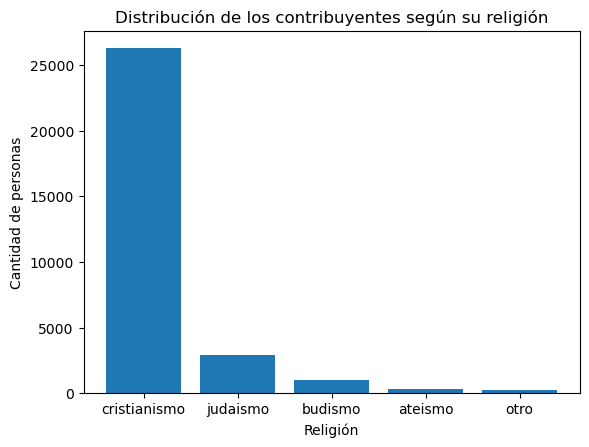

In [31]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
personas_por_religion = (df['religion'].value_counts().sort_values(ascending=False))
plt.bar(personas_por_religion.index, personas_por_religion.values)
plt.ylabel("Cantidad de personas")
plt.xlabel("Religión")
plt.title("Distribución de los contribuyentes según su religión")
plt.show()

Se ve una clara predominancia del cristianismo por sobre las otras religiones, revisamos ahora si tiene una relación con la variable target.

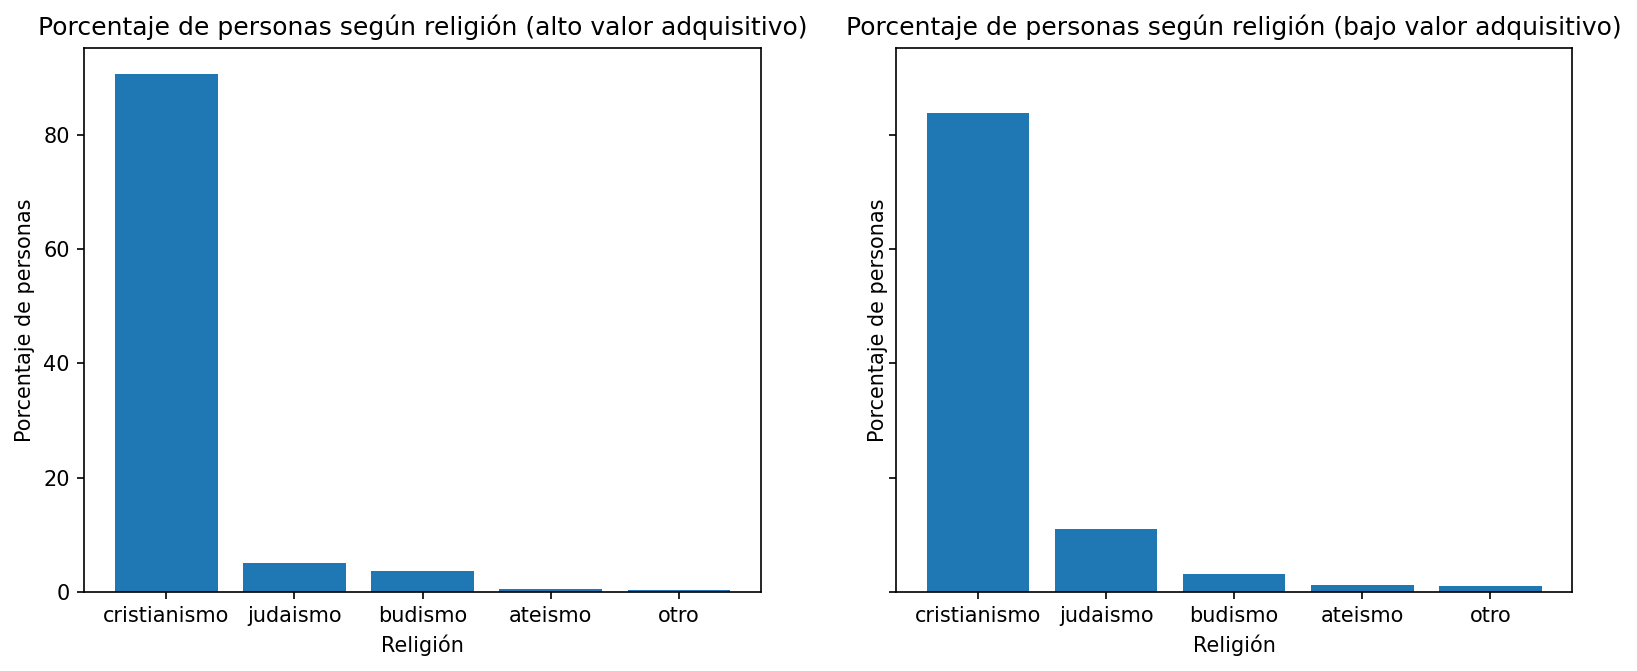

In [32]:
alto_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 1]
bajo_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 0]

porcentaje_alto_valor_adquisitivo = (
    alto_valor_adquisitivo.religion.value_counts() / 
    len(personas_con_alto_valor_adquisitivo) * 100
)
porcentaje_bajo_valor_adquisitivo = (
    bajo_valor_adquisitivo.religion.value_counts() / 
    len(bajo_valor_adquisitivo) * 100
)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=150, figsize=(6.4 * 2, 4.8))

axes[0].bar(porcentaje_alto_valor_adquisitivo.index, porcentaje_alto_valor_adquisitivo.values)
axes[0].set_title("Porcentaje de personas según religión (alto valor adquisitivo)")
axes[0].set_xlabel("Religión")
axes[0].set_ylabel("Porcentaje de personas")

axes[1].bar(porcentaje_bajo_valor_adquisitivo.index, porcentaje_bajo_valor_adquisitivo.values)
axes[1].set_title("Porcentaje de personas según religión (bajo valor adquisitivo)")
axes[1].set_xlabel("Religión")
axes[1].set_ylabel("Porcentaje de personas")

plt.show()

Por lo visto en los gráficos, no vemos una diferencia significativa en los porcentajes de personas pertenecientes a cada religión en función de sus ingresos. Por lo tanto, este feature no nos parece importante en el análisis.


## ¿Influye la edad en los ingresos de la persona?

Primero comenzamos viendo como se distribuye la edad en nuestra población según sus niveles de ingreso.

Decidimos agrupar las edades en categorías para lograr una mejor interpretación de las mismas, ya que son demasiados valores diferentes para un gráfico.

Text(0.5, 1.0, 'Cantidad de personas por edad según su nivel de ingresos')

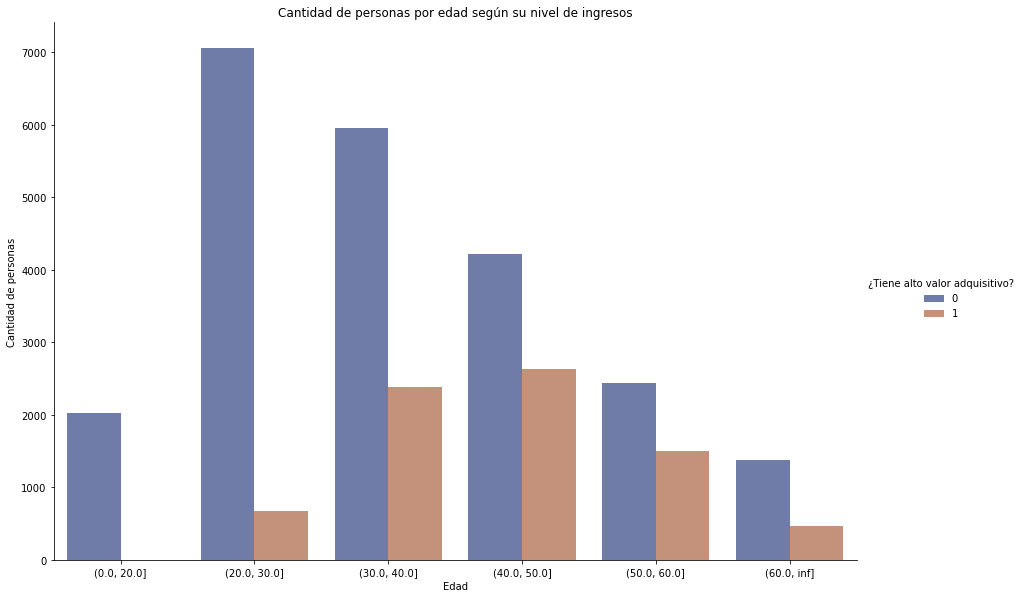

In [33]:
bins = [0, 20, 30, 40, 50, 60, np.inf]
edades = pd.cut(df['edad'], bins=bins)

tipo_ingresos_por_edad = df.groupby(by=edades)['tiene_alto_valor_adquisitivo'].value_counts()
df_aux = tipo_ingresos_por_edad.to_frame()
df_aux.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de personas'}, inplace=True)
df_aux.reset_index(inplace=True)
df_aux.rename(columns={'tiene_alto_valor_adquisitivo':'¿Tiene alto valor adquisitivo?','edad':'Edad'},inplace=True)

sns.catplot(
    data=df_aux, kind="bar",
    x="Edad", y="Cantidad de personas", hue="¿Tiene alto valor adquisitivo?",
    ci=None, palette="dark", alpha=.6, height=8,aspect=1.5
)
plt.title("Cantidad de personas por edad según su nivel de ingresos")

Es evidente que pasados los 30 años de edad se encuentra la mayor cantidad de personas con alto valor adquisitivo. También se observa que los menores o iguales a 30 años poseen una gran cantidad de personas con valor adquisitivo bajo. Ambas relaciones pueden llegar a ser importantes para el análisis.

## ¿Es el rol familiar registrado determinante en los ingresos de las personas?

Para determinarlo, vamos a ver la distribución de la población en general, según su rol familiar.

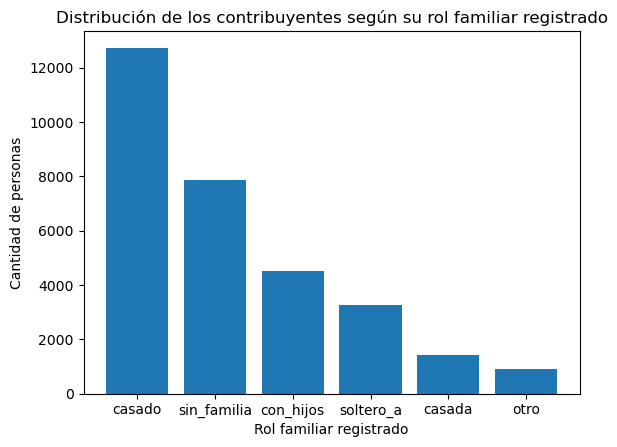

In [34]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
personas_por_rol_familiar = (df['rol_familiar_registrado'].value_counts().sort_values(ascending=False))
plt.bar(personas_por_rol_familiar.index, personas_por_rol_familiar.values)
plt.ylabel("Cantidad de personas")
plt.xlabel("Rol familiar registrado")
plt.title("Distribución de los contribuyentes según su rol familiar registrado")
plt.show()

Creemos conveniente agrupar las categorías casado y casada en una misma, llamada "casado_a".

In [35]:
df = df.replace({'rol_familiar_registrado':'casado'}, {'rol_familiar_registrado':'casado_a'})
df = df.replace({'rol_familiar_registrado':'casada'}, {'rol_familiar_registrado':'casado_a'})

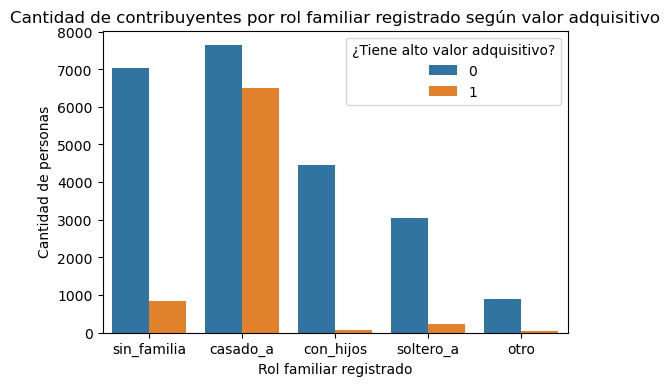

In [36]:
alto_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 1]
plt.figure(dpi=100)
sns.countplot(data=df, x='rol_familiar_registrado', hue='tiene_alto_valor_adquisitivo')
plt.title("Cantidad de contribuyentes por rol familiar registrado según valor adquisitivo")
plt.ylabel("Cantidad de personas")
plt.xlabel("Rol familiar registrado")
plt.legend(title="¿Tiene alto valor adquisitivo?")
plt.show()

Se puede observar que los contribuyentes con alto valor adquisitivo tienen, en su mayoría, el rol familiar casado_a. Los resultados son los esperados ya que habíamos encontrado resultados similares en el estado marital, donde la mayoría de las personas con alto valor adquisitivo tenían matrimonio.

## ¿Es influyente la categoría de trabajo?

Procedemos a analizar cómo se distribuyen las categorías de trabajo en la población.

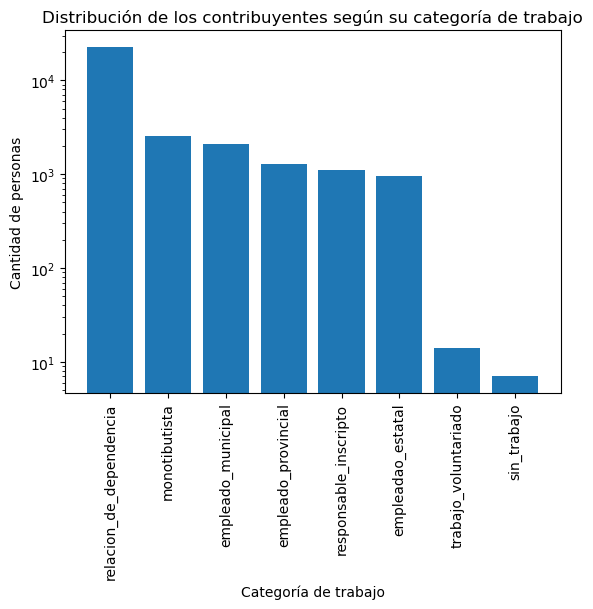

In [37]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
personas_por_categoria = (df['categoria_de_trabajo'].value_counts().sort_values(ascending=False))
plt.bar(personas_por_categoria.index, personas_por_categoria.values)
plt.ylabel("Cantidad de personas")
plt.xlabel("Categoría de trabajo")
plt.title("Distribución de los contribuyentes según su categoría de trabajo")
plt.xticks(rotation=90)
plt.yscale("log")
plt.show()

Utilizamos escala logarítmica para visualizar mejor los valores más pequeños. Hay una predominancia de los empleados en relación de dependencia por sobre los demás.

A continuación, observamos el feature dividido por si tiene o no alto valor adquisitivo. No se muestran las categorías "trabajo_voluntariado" y "sin_trabajo" ya que son valores muy bajos.

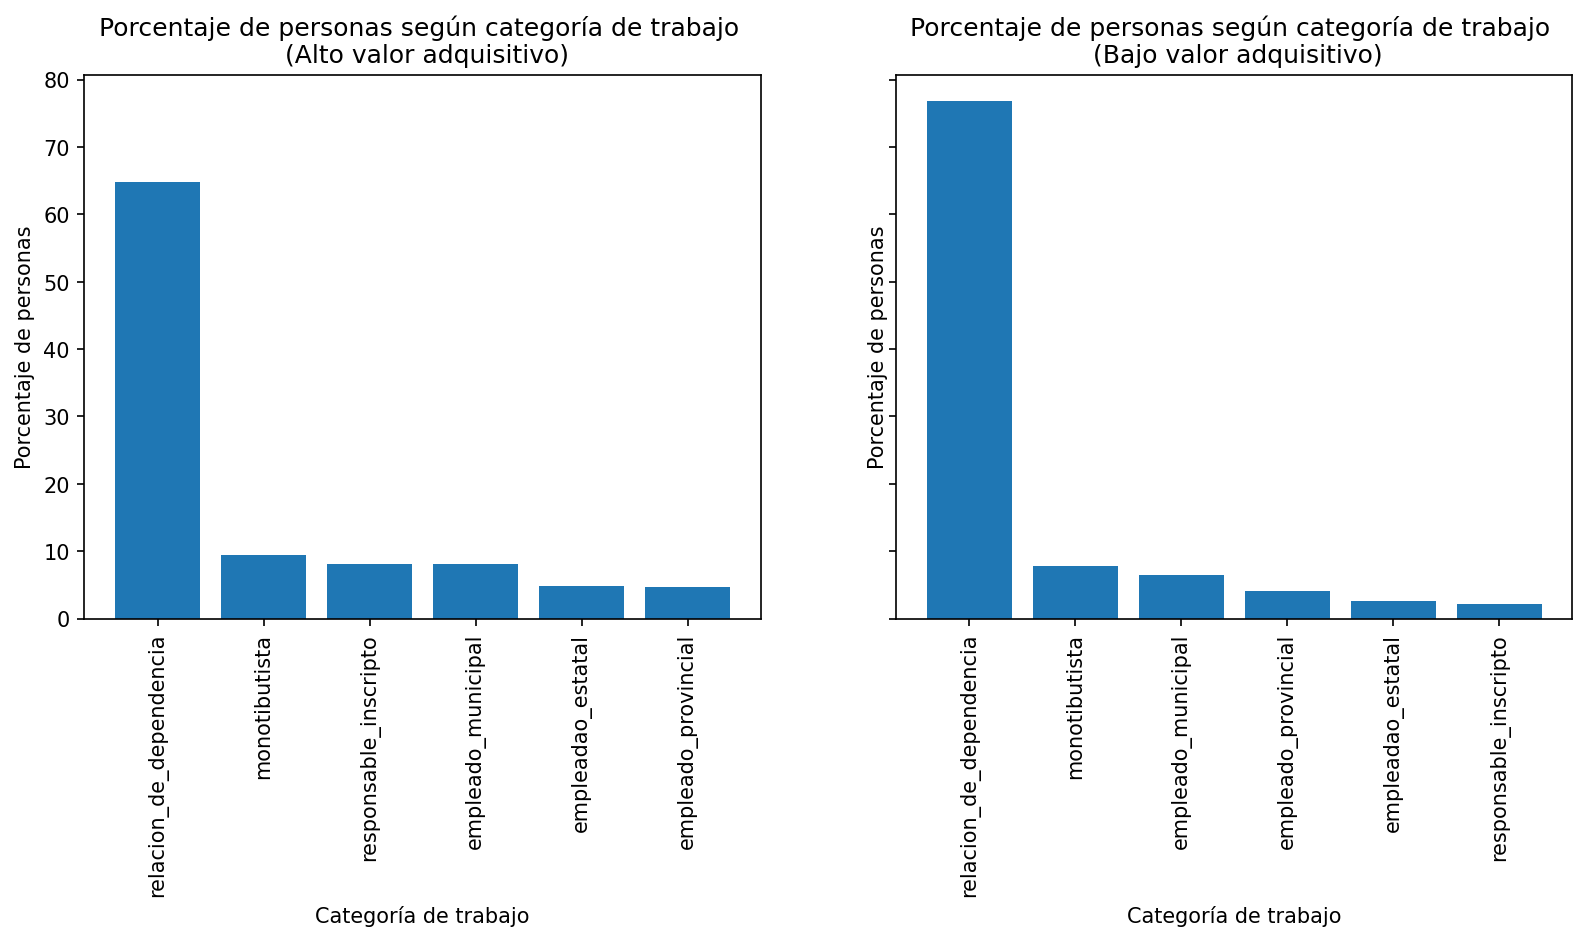

In [38]:
alto_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 1]
bajo_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 0]

porcentaje_alto_valor_adquisitivo = (
    alto_valor_adquisitivo.categoria_de_trabajo.value_counts().iloc[:6] / 
    len(alto_valor_adquisitivo) * 100
)
porcentaje_bajo_valor_adquisitivo = (
    bajo_valor_adquisitivo.categoria_de_trabajo.value_counts().iloc[:6] / 
    len(bajo_valor_adquisitivo) * 100
)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=150, figsize=(6.4 * 2, 4.8))

axes[0].bar(porcentaje_alto_valor_adquisitivo.index, porcentaje_alto_valor_adquisitivo.values)
axes[0].set_title("Porcentaje de personas según categoría de trabajo \n (Alto valor adquisitivo)")
axes[0].set_xlabel("Categoría de trabajo")
axes[0].set_ylabel("Porcentaje de personas")
plt.sca(axes[0])
plt.xticks(rotation=90)

axes[1].bar(porcentaje_bajo_valor_adquisitivo.index, porcentaje_bajo_valor_adquisitivo.values)
axes[1].set_title("Porcentaje de personas según categoría de trabajo \n (Bajo valor adquisitivo)")
axes[1].set_xlabel("Categoría de trabajo")
axes[1].set_ylabel("Porcentaje de personas")
plt.sca(axes[1])
plt.xticks(rotation=90)

plt.show()


Se ve un descenso en la cantidad de personas en relación de dependencia. Sin embargo, el gráfico no aporta la suficiente información como para determinar si influye o no en la variable target, ya que los contribuyentes se distribuyen de forma similar en ambos casos.

## ¿Es el tipo de trabajo un factor fundamental para determinar los ingresos de una persona?

Primero vamos a ver cómo se distribuyen los distintos trabajos dentro de la población.

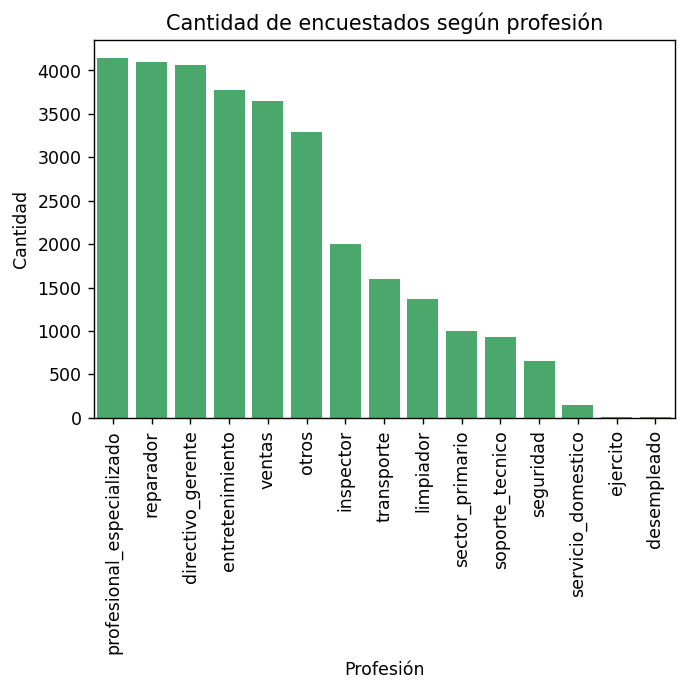

In [39]:
plt.figure(dpi=125)
sns.countplot(
    x="trabajo",
    data=df,
    order=df["trabajo"].value_counts().index,
    color=(0.23, 0.72, 0.41),
)
plt.ylabel("Cantidad")
plt.xlabel("Profesión")
plt.title("Cantidad de encuestados según profesión")
plt.xticks(rotation=90)
plt.show()

Luego, vemos cómo se distribuyen según los ingresos de la persona.

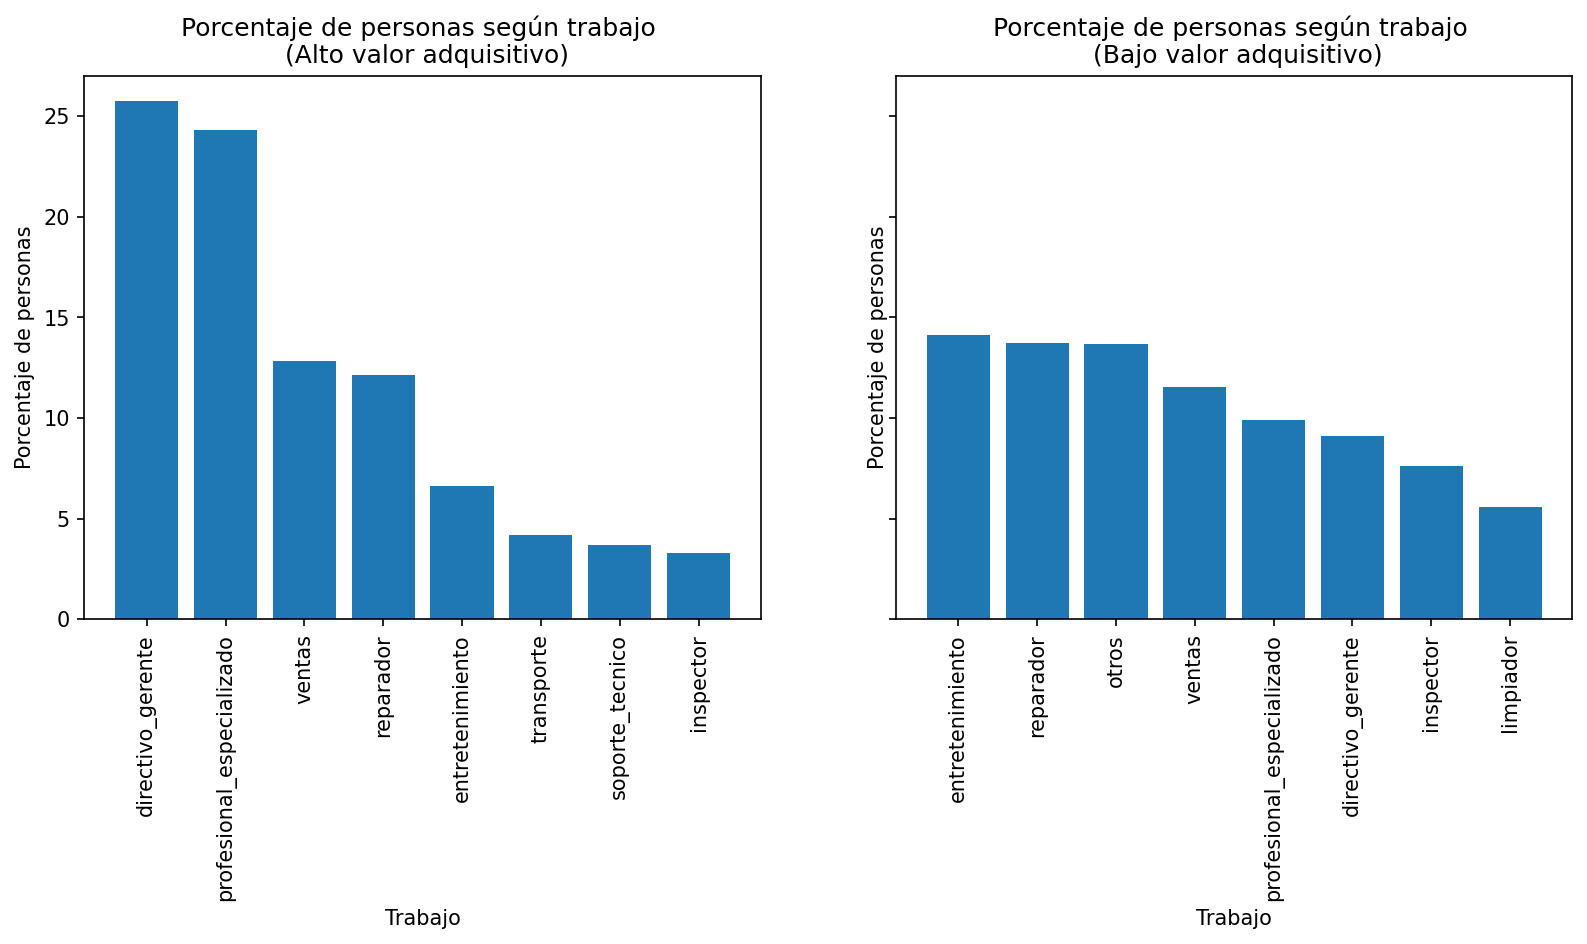

In [40]:
alto_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 1]
bajo_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 0]

porcentaje_alto_valor_adquisitivo = (
    alto_valor_adquisitivo.trabajo.value_counts().iloc[:8] / 
    len(alto_valor_adquisitivo) * 100
)
porcentaje_bajo_valor_adquisitivo = (
    bajo_valor_adquisitivo.trabajo.value_counts().iloc[:8] / 
    len(bajo_valor_adquisitivo) * 100
)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=150, figsize=(6.4 * 2, 4.8))

axes[0].bar(porcentaje_alto_valor_adquisitivo.index, porcentaje_alto_valor_adquisitivo.values)
axes[0].set_title("Porcentaje de personas según trabajo \n (Alto valor adquisitivo)")
axes[0].set_xlabel("Trabajo")
axes[0].set_ylabel("Porcentaje de personas")
plt.sca(axes[0])
plt.xticks(rotation=90)

axes[1].bar(porcentaje_bajo_valor_adquisitivo.index, porcentaje_bajo_valor_adquisitivo.values)
axes[1].set_title("Porcentaje de personas según trabajo \n (Bajo valor adquisitivo)")
axes[1].set_xlabel("Trabajo")
axes[1].set_ylabel("Porcentaje de personas")
plt.sca(axes[1])
plt.xticks(rotation=90)

plt.show()


Se puede observar que, en las personas de altos ingresos, aproximadamente el 50% de la población es directivo o profesional especializado. El otro 50% tiene ventas y reparador como categorías con mas personas, y el resto distribuidas uniformemente. En cambio, en la población con bajos ingresos, se observa una distribución bastante uniforme de las profesiones y no hay ninguna que se destaque mayoritariamente.

## ¿La cantidad de horas trabajadas influye en el valor adquisitivo de la gente?


Observamos primero cómo se distribuye la cantidad de horas trabajadas según el valor adquisitivo de las personas. Para un mejor entendimiento, y ya que hay muchos valores distintos de horas, decidimos agrupar estas en categorías.

Text(0.5, 1.0, 'Cantidad de personas por horas de trabajo registradas según su nivel de ingresos')

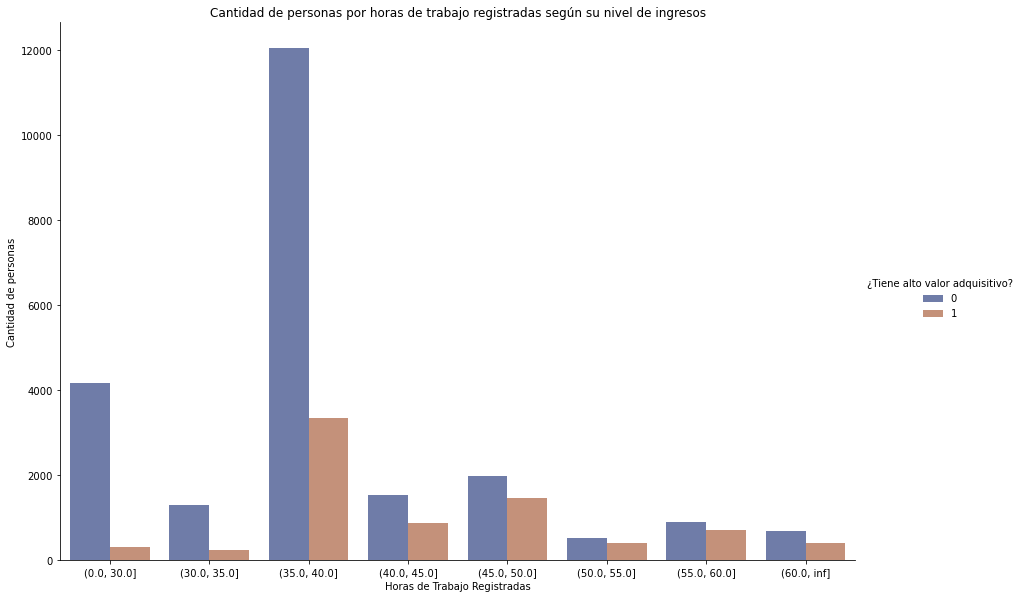

In [41]:
bins = [0, 30, 35, 40, 45, 50, 55, 60, np.inf]
edades = pd.cut(df['horas_trabajo_registradas'], bins=bins)

tipo_ingresos_por_edad = df.groupby(by=edades)['tiene_alto_valor_adquisitivo'].value_counts()
df_aux = tipo_ingresos_por_edad.to_frame()
df_aux.rename(columns={'tiene_alto_valor_adquisitivo':'Cantidad de personas'}, inplace=True)
df_aux.reset_index(inplace=True)
df_aux.rename(columns={'tiene_alto_valor_adquisitivo':'¿Tiene alto valor adquisitivo?','horas_trabajo_registradas':'Horas de Trabajo Registradas'},inplace=True)

sns.catplot(
    data=df_aux, kind="bar",
    x="Horas de Trabajo Registradas", y="Cantidad de personas", hue="¿Tiene alto valor adquisitivo?",
    ci=None, palette="dark", alpha=.6, height=8,aspect=1.5
)
plt.title("Cantidad de personas por horas de trabajo registradas según su nivel de ingresos")

En el gráfico se muestra que la mayor parte de los que tienen un bajo valor adquisitivo tiene 40 horas de trabajo registradas. Decidimos ver cómo se distribuye la cantidad de horas trabajadas alrededor de este número:

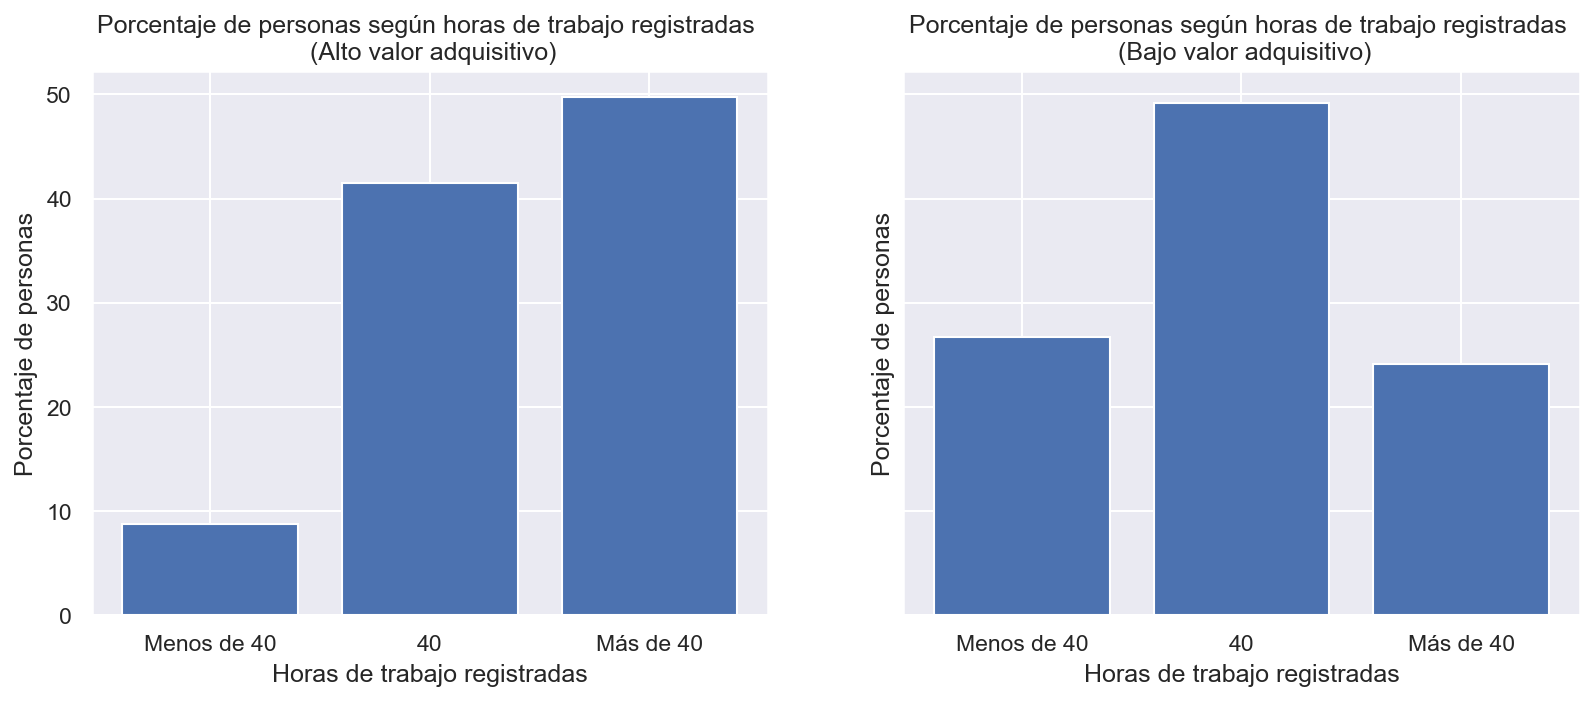

In [56]:
def determinar_horas_trabajadas(horas_trabajo):
    if horas_trabajo > 40:
        return 'Más de 40'
    elif horas_trabajo < 40:
        return 'Menos de 40'
    else:
        return '40'

df['cantidad_de_horas_trabajo'] = df['horas_trabajo_registradas'].apply(determinar_horas_trabajadas)
alto_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 1]
bajo_valor_adquisitivo = df[df['tiene_alto_valor_adquisitivo'] == 0]

porcentaje_alto_valor_adquisitivo = (
    alto_valor_adquisitivo.cantidad_de_horas_trabajo.value_counts() / 
    len(alto_valor_adquisitivo) * 100
)
porcentaje_bajo_valor_adquisitivo = (
    bajo_valor_adquisitivo.cantidad_de_horas_trabajo.value_counts() / 
    len(bajo_valor_adquisitivo) * 100
)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=150, figsize=(6.4 * 2, 4.8))

porcentaje_alto_valor_adquisitivo = porcentaje_alto_valor_adquisitivo.reindex( ['Menos de 40','40','Más de 40'])
axes[0].bar(porcentaje_alto_valor_adquisitivo.index, porcentaje_alto_valor_adquisitivo.values)
axes[0].set_title("Porcentaje de personas según horas de trabajo registradas \n (Alto valor adquisitivo)")
axes[0].set_xlabel("Horas de trabajo registradas")
axes[0].set_ylabel("Porcentaje de personas")

porcentaje_bajo_valor_adquisitivo = porcentaje_bajo_valor_adquisitivo.reindex( ['Menos de 40','40','Más de 40'])
axes[1].bar(porcentaje_bajo_valor_adquisitivo.index, porcentaje_bajo_valor_adquisitivo.values)
axes[1].set_title("Porcentaje de personas según horas de trabajo registradas \n (Bajo valor adquisitivo)")
axes[1].set_xlabel("Horas de trabajo registradas")
axes[1].set_ylabel("Porcentaje de personas")


plt.show()

Podemos ver que la mayor parte de las personas con alto valor adquisitivo trabajan más de 40 horas o 40 horas, mientras que entre los contribuyentes de bajos ingresos, las horas registradas son 40, en su mayoría, y menos de 40. Igualmente, no nos parece un factor determinante a la hora de evaluar el valor adquistivo de una persona.

De todas formas, observando el gráfico, se puede concluir que, si una persona trabaja menos de 40 horas semanales, es poco probable que tenga un alto valor adquisitivo.

Eliminamos la columna agregada, ya que solo era para el gráfico.

In [43]:
df.drop(columns=['cantidad_de_horas_trabajo'],inplace=True)



Vistas todas las variables individualmente, buscamos si existían relaciones entre las variables que nosotros consideramos importantes.



## Relación entre estado marital y cantidad de años estudiados

Luego de lo visto en el analisis individual, llegamos a la conclusión de que ambas variables parecian ser importantes para definir el valor adquisitivo de las personas. Como ambas parecen importantes, decidimos ver si existe una relación entre ellas. Para esto, decidimos poner en categorias los años estudiados, ya que teniamos muchos valores separados y en el analisis de esta categoria vimos que existian ciertos estratos que nos interesaban, sobre todo la division en los 14 años de estudio. A su vez, en lugar de analizar el estado marital, decidimos utilizar las categorias que ya habiamos visto para el analisis individual que llamamos 'Con matrimonio' y 'Sin matrimonio'

In [44]:
def determinar_rango_anios_estudiados(anios):
    if anios < 12:
        return 'Menos de 12'
    elif (anios >= 12) & (anios <= 14):
        return 'De 12 a 14'
    elif (anios > 14) & (anios <= 17):
        return 'De 15 a 17'
    else:
        return 'Más de 17'

df['rango_anios_estudiados'] = df['anios_estudiados'].apply(determinar_rango_anios_estudiados)

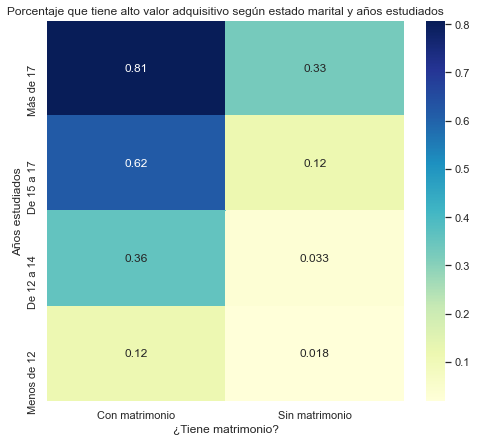

In [45]:
sns.set(rc={'figure.figsize':(8,7)})
estado_marital_anios_estudiados = pd.pivot_table(data = df, index = 'rango_anios_estudiados', values = 'tiene_alto_valor_adquisitivo', columns = 'tiene_matrimonio')
estado_marital_anios_estudiados.sort_index(ascending =  False, inplace = True)
estado_marital_anios_estudiados = estado_marital_anios_estudiados.reindex( ['Más de 17','De 15 a 17','De 12 a 14','Menos de 12'],axis = 0)

mascara = estado_marital_anios_estudiados.isnull()
g = sns.heatmap(estado_marital_anios_estudiados, mask = mascara, cmap="YlGnBu", annot=True)
g.set_ylabel("Años estudiados")
g.set_xlabel("¿Tiene matrimonio?")
g.set_title("Porcentaje que tiene alto valor adquisitivo según estado marital y años estudiados")

plt.show()

Se puede observar una clara relación entre la cantidad de años de estudio y el hecho de tener matrimonio. A partir de los 15 años de estudio, las personas con matrimonio tienen en su mayoría alto poder adquisitivo.

## Relación entre edad, estado marital y años de estudio

Como vimos en el analisis anterior, existe una relacion entre el estado y los años de estudio. Decidimos analizar las mismas categorias que antes, pero ahora utilizando un dataframe que unicamente tiene a los mayores de 30 años. Hacemos esto, debido a que al analizar la categoria 'edad' vimos que hay una gran cantidad de personas menores a los 30 años que tienen bajo valor adquisitivo.

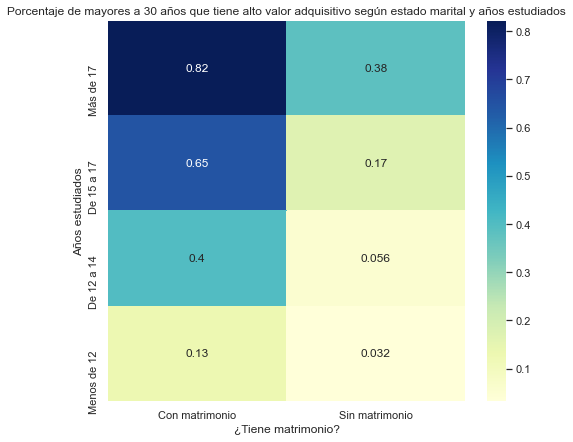

In [52]:
sns.set(rc={'figure.figsize':(8,7)})
estado_marital_anios_estudiados = pd.pivot_table(data = df[df['edad']>30], index = 'rango_anios_estudiados', values = 'tiene_alto_valor_adquisitivo', columns = 'tiene_matrimonio')
estado_marital_anios_estudiados.sort_index(ascending =  False, inplace = True)
estado_marital_anios_estudiados = estado_marital_anios_estudiados.reindex( ['Más de 17','De 15 a 17','De 12 a 14','Menos de 12'],axis = 0)

mascara = estado_marital_anios_estudiados.isnull()
g = sns.heatmap(estado_marital_anios_estudiados, mask = mascara, cmap="YlGnBu", annot=True)
g.set_ylabel("Años estudiados")
g.set_xlabel("¿Tiene matrimonio?")
g.set_title("Porcentaje de mayores a 30 años que tiene alto valor adquisitivo según estado marital y años estudiados")

plt.show()

Se puede observar una mejora en los porcentajes de personas con alto valor adquisitivo, ya que al aplicar el filtro de la edad no tenemos en cuenta muchas personas que tenian bajo nivel adquisitivo

## Conclusiones del análisis

A partir de los datos recolectados hemos podido obtener las siguientes conclusiones:
+ Las variables mas importantes que encontramos para determinar si una persona tiene alto valor adquisitivo es su estado marital y la cantidad de años estudiados. A partir de esta relación, basamos nuestro baseline.
+ Hay una gran correlación entre los features estado marital y rol familiar registrado.
+ Hay una gran correlación entre los features años estudiados y educacion alcanzada.
+ Las personas que tienen ganancias en la bolsa mayores a $5000 son en su gran mayoria personas con alto valor adquisitivo.
+ No creemos que las features religión, género,categoria de trabajo y barrio tengan suficiente información como para definir los ingresos de una persona. 

Según el análisis, nosotros recomendariamos a la agencia que sus campañas sean dirigidas a las personas que poseean más de 14 años de estudio, que esten casadas y sean mayores a 30 años. Además, les aconsejariamos que se enfoquen en las personas que tienen ganancias en la bolsa argentina mayores a $5000.

## Baseline

In [59]:
def baseline(df: pd.DataFrame):
  
    gano_mas_de_5000_en_bolsa = df['ganancia_perdida_declarada_bolsa_argentina'] > 5000
    estudio_mas_de_14_anios = df['anios_estudiados'] > 14
    tiene_matrimonio = df['tiene_matrimonio'] == 'Con matrimonio'
    tiene_mas_de_30_anios = df['edad'] > 30
    
    df['prediccion_alto_valor_adquisitivo'] = 0
    df.loc[gano_mas_de_5000_en_bolsa,'prediccion_alto_valor_adquisitivo'] = df.loc[gano_mas_de_5000_en_bolsa,'prediccion_alto_valor_adquisitivo'] + 1 
    df.loc[estudio_mas_de_14_anios & tiene_matrimonio & tiene_mas_de_30_anios ,'prediccion_alto_valor_adquisitivo'] = df.loc[estudio_mas_de_14_anios & tiene_matrimonio & tiene_mas_de_30_anios,'prediccion_alto_valor_adquisitivo'] + 1 
    
    prediccion_mayor_a_uno = df['prediccion_alto_valor_adquisitivo'] > 1
    
    df.loc[prediccion_mayor_a_uno ,'prediccion_alto_valor_adquisitivo'] = 1
    
    resultado = df['prediccion_alto_valor_adquisitivo'].values.tolist()
    pred = accuracy_score(df.tiene_alto_valor_adquisitivo, df.prediccion_alto_valor_adquisitivo)
    df.drop(columns=['prediccion_alto_valor_adquisitivo'],inplace=True)    
    return resultado

In [60]:
(baseline(df) == df['tiene_alto_valor_adquisitivo']).mean().round(5)

0.83515

In [61]:
pred = pd.Series(np.zeros(len(df)))
pred[(df.ganancia_perdida_declarada_bolsa_argentina > 5000)] = 1
pred[(df.anios_estudiados > 14) & (df.tiene_matrimonio == 'Con matrimonio') & (df.edad > 30)] = 1
print(pred.value_counts())
accuracy_score(df.tiene_alto_valor_adquisitivo, pred)

0.0    25046
1.0     5679
dtype: int64


0.8351505288852725